<p>Team Members:
<p>1) Geetesh Nikhade - gpn218</p>
<p>2) Rahul Keshwani - ryk248</p>

<p> Dataset Links:</p>

[Train Data] (https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv)

[Test Data] (https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv)

# Importing Libraries

In [1]:
import time
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings('ignore')

# Reading and Manipulating data

### 1) Training Data

In [2]:
train_data = pd.read_csv("UNSW_NB15_training-set.csv")

#Shuffling training data to incorporate randomness
train_data = shuffle(train_data)
train_data.reset_index(inplace=True)
train_data.drop('index', 1, inplace=True)

#Creating a copy of data for future use
data_copy = pd.DataFrame(train_data)
train_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,74918,0.561825,tcp,-,FIN,10,6,2516,268,26.698706,...,1,2,0,0,0,1,2,0,Normal,0
1,17515,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,16,36,0,0,0,16,36,0,Generic,1
2,59762,0.000011,udp,dns,INT,2,0,114,0,90909.090200,...,2,2,0,0,0,2,9,0,Generic,1
3,37814,0.075200,udp,-,CON,4,4,568,312,93.085108,...,2,4,0,0,0,9,8,0,Normal,0
4,10853,59.478535,ospf,-,INT,80,0,21760,0,1.328210,...,1,1,0,0,0,2,1,0,Exploits,1


### 2) Testing data

In [3]:
test_data = pd.read_csv("UNSW_NB15_testing-set.csv")

#Shuffling testing data
test_data = shuffle(test_data)
test_data.reset_index(inplace=True)
test_data.drop(['id', 'index'], 1, inplace=True)

In [4]:
target = train_data.iloc[:,[-1]]
target_category = train_data.iloc[:,[-2]]
target_category = target_category.astype('str')
# data.drop(['attack_cat','label','id'], 1, inplace=True)
train_data.drop(['id'], 1, inplace=True)

In [5]:
#Separating numerical and categorical features

numerical_attributes = []
categorical_attributes = []
for col in train_data.columns:
    if train_data[col].dtype != object:
        numerical_attributes.append(col)
    else:
        categorical_attributes.append(col)

# Data Preprocessing

### 1) Normalizing training data (Min-Max Normalization)

In [6]:
#Fitting Min-Max Scaler 
scaler = MinMaxScaler()
scaler.fit(train_data[numerical_attributes])
normalized_data = pd.DataFrame(scaler.transform(train_data[numerical_attributes]))
normalized_data.columns = numerical_attributes

#Add remaining categorical attributes to normalized data
normalized_data['proto'] = train_data['proto']
normalized_data['service'] = train_data['service']
normalized_data['state'] = train_data['state']
normalized_data['attack_cat'] = train_data['attack_cat']

#Quick glance of the normalized data
normalized_data.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto,service,state,attack_cat
0,9.363752e-03,0.000845,0.000545,0.000174,0.000018,0.000027,0.996078,0.996047,6.122254e-06,0.000153,...,0.0,0.0,0.000000,0.016393,0.0,0.0,tcp,-,FIN,Normal
1,1.500000e-07,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,9.617817e-03,0.000000,...,0.0,0.0,0.254237,0.573770,0.0,1.0,udp,dns,INT,Generic
2,1.833334e-07,0.000094,0.000000,0.000006,0.000000,0.090909,0.996078,0.000000,7.869123e-03,0.000000,...,0.0,0.0,0.016949,0.131148,0.0,1.0,udp,dns,INT,Generic
3,1.253334e-03,0.000282,0.000363,0.000038,0.000021,0.000093,0.121569,0.114625,8.602723e-06,0.001196,...,0.0,0.0,0.135593,0.114754,0.0,0.0,udp,-,CON,Normal
4,9.913091e-01,0.007421,0.000000,0.001514,0.000000,0.000001,0.996078,0.000000,5.486305e-07,0.000000,...,0.0,0.0,0.016949,0.000000,0.0,1.0,ospf,-,INT,Exploits


#### Since the features had a very varied range, we decided to perform Normalization. One reason for selecting Min-Max Normalization is, even after the scaling the data, it keeps the relationship between the original data intact.

### 2) Normalizing testing data (Min-Max Normalization)

In [7]:
scaler.fit(test_data[numerical_attributes])
normalized_test_data = pd.DataFrame(scaler.transform(test_data[numerical_attributes]))
normalized_test_data.columns = numerical_attributes

normalized_test_data['attack_cat'] = test_data['attack_cat']

normalized_test_data.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat
0,1.000000e-07,0.000104,0.000000,0.000006,0.000000,0.166667,0.996078,0.000000,0.011579,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,Exploits
1,1.500000e-07,0.000104,0.000000,0.000007,0.000000,0.111111,0.996078,0.000000,0.008461,0.000000,...,0.333333,0.500000,0.0,0.0,0.000000,0.254237,0.508197,0.0,1.0,Generic
2,2.214470e-02,0.004680,0.001093,0.003939,0.000036,0.000043,0.996078,0.992126,0.000050,0.000130,...,0.000000,0.015625,0.0,0.0,0.033333,0.000000,0.016393,0.0,1.0,Fuzzers
3,1.000000e-07,0.000104,0.000000,0.000013,0.000000,0.166667,0.996078,0.000000,0.022267,0.000000,...,0.022222,0.046875,0.0,0.0,0.000000,0.016949,0.049180,0.0,1.0,Reconnaissance
4,4.218751e-03,0.000936,0.000547,0.000061,0.000018,0.000059,0.996078,0.992126,0.000004,0.000316,...,0.000000,0.000000,0.0,0.0,0.033333,0.033898,0.000000,0.0,1.0,Reconnaissance


### 3) Label Encoding for Attack Category

In [8]:
labelEncoder = LabelEncoder()

# Fitting Label Encoder on Train Data
normalized_data['attack_cat_labels'] = labelEncoder.fit_transform(normalized_data.iloc[:,-1])

# Fitting Label Encoder on Test Data
normalized_test_data['attack_cat_labels'] = labelEncoder.fit_transform(test_data.iloc[:,-2])

# Keeping a mapping for each network attack category
mapping = dict(zip(labelEncoder.transform(labelEncoder.classes_), labelEncoder.classes_))

#Quick of data after Label Encoding
normalized_data.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto,service,state,attack_cat,attack_cat_labels
0,9.363752e-03,0.000845,0.000545,0.000174,0.000018,0.000027,0.996078,0.996047,6.122254e-06,0.000153,...,0.0,0.000000,0.016393,0.0,0.0,tcp,-,FIN,Normal,6
1,1.500000e-07,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,9.617817e-03,0.000000,...,0.0,0.254237,0.573770,0.0,1.0,udp,dns,INT,Generic,5
2,1.833334e-07,0.000094,0.000000,0.000006,0.000000,0.090909,0.996078,0.000000,7.869123e-03,0.000000,...,0.0,0.016949,0.131148,0.0,1.0,udp,dns,INT,Generic,5
3,1.253334e-03,0.000282,0.000363,0.000038,0.000021,0.000093,0.121569,0.114625,8.602723e-06,0.001196,...,0.0,0.135593,0.114754,0.0,0.0,udp,-,CON,Normal,6
4,9.913091e-01,0.007421,0.000000,0.001514,0.000000,0.000001,0.996078,0.000000,5.486305e-07,0.000000,...,0.0,0.016949,0.000000,0.0,1.0,ospf,-,INT,Exploits,3


#### Assigned a label to each attack category in order to perfrom correlation analysis and train a multiclass classification model.

# Exploratory Data Analysis

### 1) Correlation of 'label' and 'attack catgeory' with other features

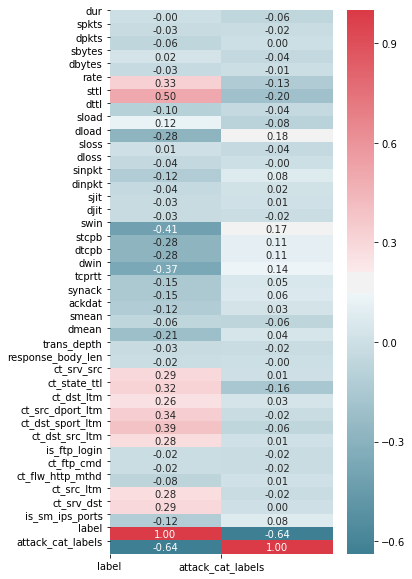

In [9]:
#Calculating corrleation
corr = normalized_data.corr()

#Plotting a heatmap for visualizing correlation.
plt.figure(figsize=(5,10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr.iloc[:,-2:], cmap=colormap, annot=True, fmt=".2f")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.xticks(range(len(corr.iloc[:,-2:].columns)), corr.iloc[:,-2:].columns)
plt.show()

<p>We can see that <b>label</b> is highly correlated with features like Source Time to Live <b>(sttl)</b>, Count of packets from same source/destination to the same source port/destination port<b>(ct_src_dport_ltm</b> and <b>ct_dst_sport_ltm)</b>. This basically gives us some idea about which features can contribute in classifying a network packet.</p>

<p>On the other hand, <b>attack_cat_labels</b> depends on features like Destination Load <b>(dload)</b>, Source and Destination TCP window advertisement value <b>(swin</b> and <b>dwin)</b>. Based on our domain knowledge we feel that these features do not make complete sense and hence we perform <b>Feature importance</b> for each attack category in the <b>"Feature Importances"</b> section. </p>

### 2) Distribution of Attack Type

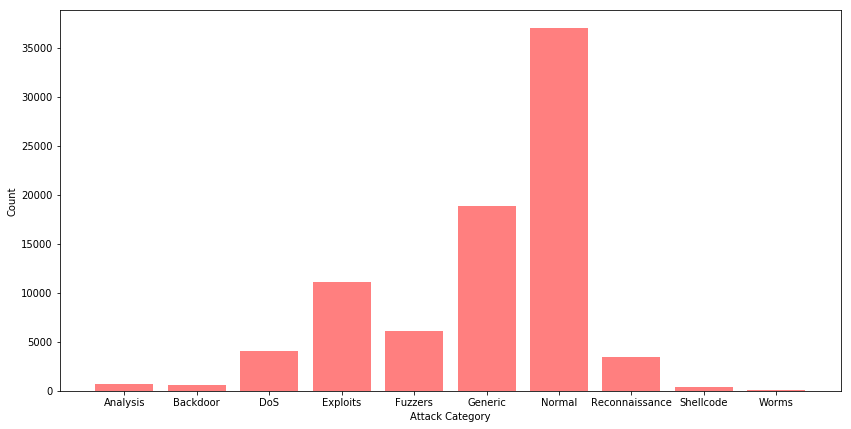

In [10]:
attack_cat_count = target_category.groupby(['attack_cat'])['attack_cat'].count()
x_values = list(attack_cat_count.index)
x_pos = np.arange(len(attack_cat_count.values))

plt.figure(figsize=(14,7))
plt.bar(x_pos, list(attack_cat_count.values), align='center', alpha=0.5, color='red')
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.xticks(x_pos, x_values)
plt.show()

<p>The above graph shows that there is imbalance in the count of each attack category. This imbalance in the data will not cause a problem while performing <b>Binary classification</b> since there is a balance bewteen the count of attack and non-attack entries.</p> 

<p>Although, the class imbalance can affect the predictions while performing <b>Multiclass classification</b> and can result in a higher number of <b>False Negatives</b>. Well, we can't upscale or downscale the number of samples, so we plan to do some hyperparameter tuning to attain good results.</p>

### 3) Top 3 protocols used for each attack type

In [11]:
#Function to plot pie chart
def plotPieChart(cat, attack_proto, i):
    labels = list(attack_proto[cat].head(3).index)
    sizes = list(attack_proto[cat].head(3).values)
    colors = ['#ff9999','#66b3ff','#99ff99']

    plt.subplot(4, 4, i)
    plt.title(cat, y=1.05, fontweight='bold')
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180)
    plt.axis('equal')

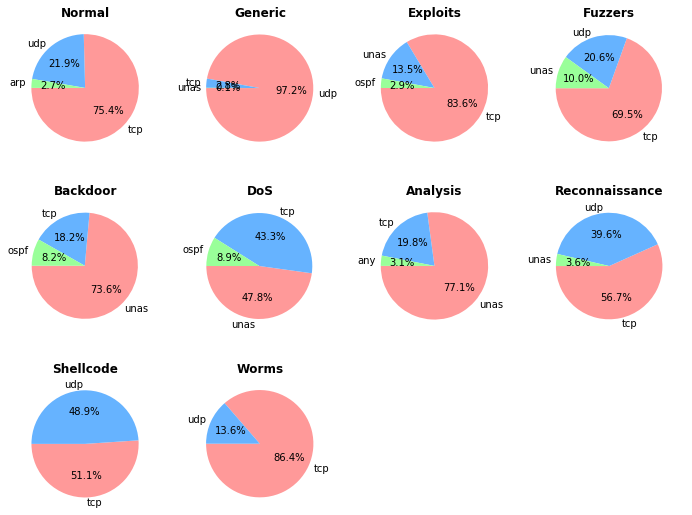

In [12]:
attack_proto = data_copy.groupby(['attack_cat','proto'])['proto'].count().sort_values(ascending=False)

attack_types = target_category['attack_cat'].unique()
count = 1
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace = 0.5)
for cat in attack_types:
    plotPieChart(cat, attack_proto, count)
    count += 1
plt.show()

### 4) Average bytes transmitted from source for each attack type

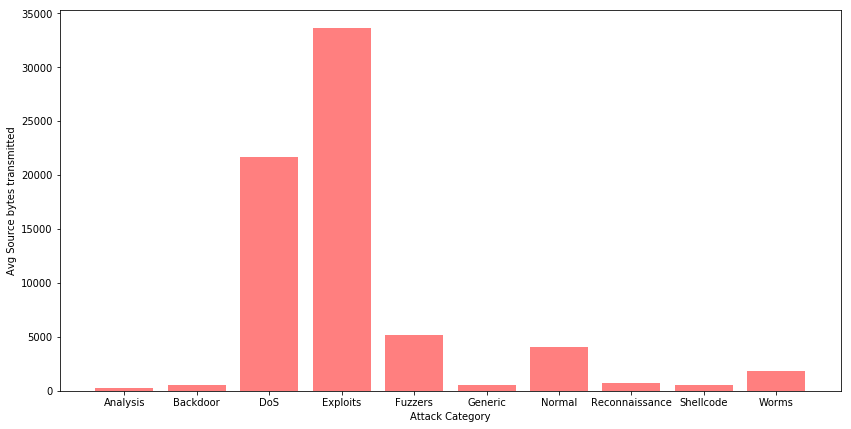

In [13]:
avg_attack_bytes = data_copy.groupby('attack_cat')['sbytes'].mean()
x_pos = np.arange(len(avg_attack_bytes.values))
x_values = list(avg_attack_bytes.index)
y_values = list(avg_attack_bytes.values)

plt.figure(figsize=(14,7))
plt.bar(x_pos, y_values, align='center', alpha=0.5, color='red')
plt.xlabel('Attack Category')
plt.ylabel('Avg Source bytes transmitted')
plt.xticks(x_pos, x_values)
plt.show()

<p>The graph above tells us that <b>DoS</b> and <b>Exploits</b> are 2 types of network attacks which require a large number of source bytes to be transmitted from source to destination. This makes sense since these network attacks are meant to jam the network so that genuine users are unable to use the service.<p> 

### 5) Average Source to Destination Time To Live value for different attack types

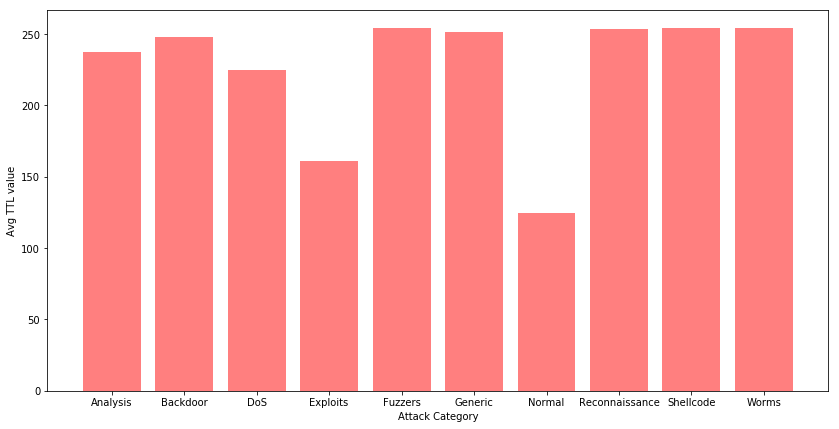

In [14]:
avg_attack_ttl = data_copy.groupby('attack_cat')['sttl'].mean()
x_pos = np.arange(len(avg_attack_ttl.values))
x_values = list(avg_attack_ttl.index)
y_values = list(avg_attack_ttl.values)

plt.figure(figsize=(14,7))
plt.bar(x_pos, y_values, align='center', alpha=0.5, color='red')
plt.xlabel('Attack Category')
plt.ylabel('Avg TTL value')
plt.xticks(x_pos, x_values)
plt.show()

<p> Time to Live value <b>(ttl)</b> defines the hop count for a network packet and can hold a maximum value of 255. From the graph above we can see that almost every attack type has an average time to live value of around 255 which will allow them to hop on the network as far as possible. Whereas, for a normal packet it is 128 which restricts it to travel only within the continent.</p>

# Feature Importances

In [15]:
# Function for calculating feature importances

def get_feature_importance(parameter_dataset, packet_type):
    tree_model = ExtraTreesClassifier()
    temp_df = parameter_dataset[numerical_attributes]
    temp_df.drop('label', axis=1, inplace=True)
    tree_model = tree_model.fit(temp_df, parameter_dataset['label'])
    return tree_model.feature_importances_

<p>We are using <b>Extra Tree Classifier</b> for finding feature importances. We chose a Tree based model since it generates multiple trees and more an attribute is used to make key decisions with decision tree, the higher is the relative importance. Extra Tree Classifier also randomizes the cut point during tree construciton and hence leads to excellent variation reduction.</p>

### 1) Overall feature importance

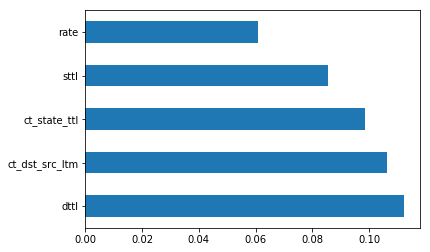

In [16]:
#Plotting feature importances

x_labels = numerical_attributes[:]
x_labels.remove('label')

feature_importances = pd.Series(get_feature_importance(normalized_data, 'Normal'), index=x_labels)
feature_importances.nlargest(5).plot(kind='barh')
plt.show()

<p> The above feature importance plot gives us a basic idea that not all the features are going to be important while performing <b>Binary classification</b>. Since the 5th highest feature has received an importance of around 0.05 (which is quite low), taking any features after that will have even lesser importance and hence using 4-5 features for the classificaiton task is a good option.</p> 

### 2) Network Attack type - Feature Importance

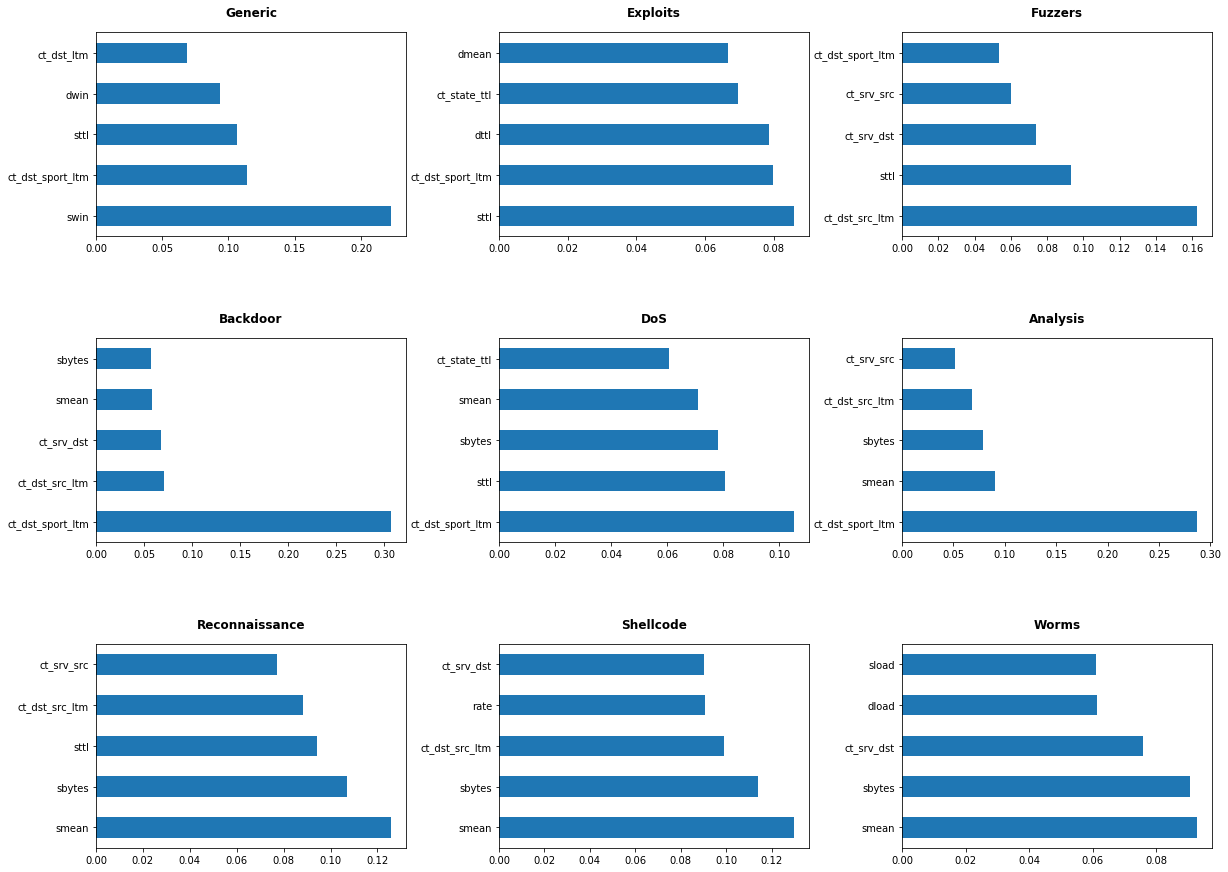

In [17]:
attack_types = normalized_data['attack_cat'].unique()

x_labels = numerical_attributes[:]
x_labels.remove('label')
count = 1

plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace = 0.5, wspace=0.3)

for each_attack in attack_types:
    if each_attack != 'Normal':
        plt.subplot(3, 3, count)
        plt.title(each_attack, y=1.05, fontweight='bold')
        
        data = normalized_data[(normalized_data['attack_cat'] == each_attack) | (normalized_data['attack_cat'] == 'Normal')]
        feature_importances = pd.Series(get_feature_importance(data, each_attack), index=x_labels)
        feature_importances.nlargest(5).plot(kind='barh')
        count += 1
plt.show()

<p> The graphs above show the <b>feature importance</b> for each attack category. Although, the top feature for each attack type is different, the top 5 for each of them are mostly the same (the order of occurence is different). Hence, some of the top features are: Source Bytes <b>(sbytes)</b>, Mean packet size transmitted from source <b>(smean)</b>, Source Time to Live value <b>(sttl)</b>, Count of packets from same destination to the same source port <b>(ct_dst_sport_ltm)</b> and Number of connections between same source and destination address <b>(ct_dst_src_ltm)</b>.

# Modeling the data

#### We are going to implement 2 models for performing both Binary and Multiclass classification

#### 1) Random Forest - We select Random Forest over Decision Trees since it overcomes the problem of overfitting by using the concept of Bagging. Since Random Forest creates multiple trees and for each of the tree it identifies the best split feature from a random subset of features, it reduces variance and hence reduces overfitting.

#### 2) XGBoost - This model is built on top of Decision Trees and the Boosting technique. XGBoost is an ensemble technique where new models are added to correct the errors made by existing models. 

### 1) Random Forest - Binary classification

#### Performing Grid search to find best parameter combination.

<p> Commenting this section because it takes a long time to run. We ran it on <b>Google Colab</b> to get the results. You can find them attached below.</p>

In [18]:
# parameters = {'min_samples_split':[2,10,100,200], 'min_samples_leaf':[5,10,150,200], 'max_leaf_nodes':[4,50,100,150]}
# rf_model = RandomForestClassifier(criterion='gini', n_estimators=50)

# clf = GridSearchCV(rf_model, parameters, cv=10)
# clf.fit(normalized_data.iloc[:,:-5], normalized_data.iloc[:,-5:-4])

<p> <b>Following is the output from Grid search.</b> </p>
<p>GridSearchCV(cv=10, error_score='raise',</p>
<p>       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',</p>
<p>            max_depth=None, max_features='auto', max_leaf_nodes=None,</p>
<p>            min_impurity_decrease=0.0, min_impurity_split=None,</p>
<p>            min_samples_leaf=1, min_samples_split=2,</p>
<p>            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,</p>
<p>            oob_score=False, random_state=None, verbose=0,</p>
<p>            warm_start=False),</p>
<p>       fit_params=None, iid=True, n_jobs=1,</p>
<p>       param_grid={'min_samples_split': [2, 10, 100, 200], 'min_samples_leaf': [5, 10, 150, 200], 'max_leaf_nodes': [4, 50, 100, 150]},</p>
<p>       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',</p>
<p>       scoring=None, verbose=0)</p>

In [19]:
#clf.best_params_

<p> <b>Following are the best parameters for the Random Forest Model</b></p>
<p> {'max_leaf_nodes': 150, 'min_samples_leaf': 5, 'min_samples_split': 10} </p>

#### Fitting the model

<p> The parameters used with the model below were found using GridSearch (results shown above). We have limited the number of features to 4 since the overall feature importance plot gave us an idea of how many featurs to use.</p>

In [20]:
rf_binary = RandomForestClassifier(n_estimators=80, random_state=42, criterion='gini', max_leaf_nodes=150, min_samples_leaf=5, min_samples_split=10, max_features=4)
rf_binary.fit(normalized_data.iloc[:,:-6], normalized_data.iloc[:,-6:-5])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=150,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
rf_binary_feature_importances = pd.DataFrame(rf_binary.feature_importances_, index = normalized_data.iloc[:,:-6].columns, columns=['importance']).sort_values('importance', ascending=False)
rf_binary_feature_importances.head(5)

,importance
sttl,0.104861
ct_dst_src_ltm,0.083504
ct_state_ttl,0.054986
sbytes,0.051820
smean,0.050896


#### Generating predictions

In [22]:
rf_binary_predictions = rf_binary.predict(normalized_test_data.iloc[:,:-3])

#### Calculating Accuracy, Precision and Recall scores

In [23]:
# Calculating accuracy
rf_binary_accuracy = accuracy_score(normalized_test_data.iloc[:,-3:-2], rf_binary_predictions)

# Calculating precision
rf_binary_precision = precision_score(normalized_test_data.iloc[:,-3:-2], rf_binary_predictions, average='weighted')

# Calculating recall
rf_binary_recall = recall_score(normalized_test_data.iloc[:,-3:-2], rf_binary_predictions, average='weighted')

### 2) XGBoost - Binary Classification

#### Performing PCA to encode 49 features into a feature space of 20 principal components

#### PCA - The reason of doing PCA is to first reduce the dimensions by reducing the number of features. Secondly, PCA very well captures how one variable is associated to another and then maps them to a new feature space. Hence, does a good job of combining the predictors.

In [24]:
pca = PCA(n_components=20)
principal_components = pca.fit_transform(normalized_data[numerical_attributes].drop(['label'], axis=1))
principal_components = pd.DataFrame(principal_components)
principal_components = pd.concat([principal_components, target], axis=1)
principal_components.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,-0.868716,-0.512787,-0.112324,0.033466,-0.234440,0.073032,-0.081790,0.050215,0.081033,0.005153,...,0.028629,-0.010975,-0.013544,-0.007035,0.004793,-0.014606,-0.026150,-0.016321,0.001294,0
1,1.129507,-0.235240,0.541919,0.066288,-0.000630,-0.019814,-0.004504,-0.002674,0.027285,0.014528,...,0.175150,0.035432,-0.000055,0.014273,-0.124754,-0.043424,0.031566,-0.000947,-0.023769,1
2,0.875196,-0.017280,-0.356324,-0.114244,0.000584,-0.014870,-0.028280,-0.040720,0.021613,-0.025471,...,0.027121,0.006963,-0.014506,-0.000988,-0.027303,0.039837,-0.038950,-0.000146,0.019408,1
3,0.639253,0.681789,-0.160516,0.383142,-0.003487,-0.189475,-0.121062,0.050690,-0.094138,-0.076337,...,0.004658,-0.015092,-0.010298,-0.014680,0.089557,-0.077313,-0.031635,-0.006099,-0.026306,0
4,0.819580,0.005650,-0.506277,-0.107529,0.001734,-0.000040,0.035115,0.105919,0.034869,0.148769,...,-0.209011,0.288038,0.857432,-0.057363,0.036974,-0.034983,0.051976,-0.113118,0.020571,1


#### Applying PCA to test data

In [25]:
test_components = pca.fit_transform(normalized_test_data.iloc[:,:-3])
test_components = pd.DataFrame(test_components)
test_components.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.741747,0.007253,-0.468320,-0.180085,-0.001799,0.023978,-0.047536,0.007488,-0.019354,-0.051420,0.009548,-0.029444,-0.042385,-0.004248,-0.014756,0.019197,0.005247,-0.018375,0.004055,-0.006281
1,-1.003347,-0.210202,0.465627,0.073717,0.000789,-0.009644,0.012666,0.017462,-0.096896,-0.009963,-0.055296,0.149692,0.024876,-0.018206,-0.051854,-0.065668,-0.002153,0.013589,-0.003256,0.021642
2,1.013201,-0.607204,-0.189022,0.012147,-0.221019,-0.010550,0.419497,-0.176460,0.021411,0.323873,-0.223779,-0.079651,-0.003516,0.004144,-0.029724,-0.007740,0.003389,0.026235,-0.004943,-0.004604
3,-0.763586,-0.012516,-0.391475,-0.160597,-0.001431,0.020451,-0.022132,-0.002241,-0.019024,-0.026265,-0.008660,-0.004241,-0.034688,-0.006197,-0.014633,0.012539,0.006221,-0.016136,0.004270,-0.005209
4,0.913704,-0.569783,-0.193126,0.088870,0.398550,0.186009,-0.001690,0.051852,-0.005740,-0.122719,-0.018712,-0.049053,0.025422,0.000941,0.010303,-0.003716,-0.010889,0.003459,-0.013823,0.007161


#### Creating DMatrix which works as an input for XGBoost Classifier. Also, setting parameters for the model

#### Parameter selection - 
#### 1) max_depth = 4 -> SInce we are selecting top 5 eigen vectors, we go ahead with a maximum depth of 4.
#### 2) objective = 'binary:logistic' -> The following objective function us used since we are performing Binary classification and since we want the output as class probabilities and not simply labels.
#### 3) colsample_bytree = 0.4 -> To avoid some columns from taking too much credit for prediction, we keep this value to be 0.4 and not more.

In [26]:
# Creating DMatrix for train and test data.
dtrain = xgb.DMatrix(principal_components.iloc[:,:5], label=principal_components['label'])
dtest = xgb.DMatrix(test_components.iloc[:,:5], label=normalized_test_data.iloc[:,-3])

# Parameters for the model
param = {'colsample_bytree': 0.4,
         'silent': True,
         'max_depth': 4,
         'objective':'binary:logistic'
        }
num_rounds = 18

#### Fitting the model

In [27]:
xgb_binary = xgb.train(param, dtrain, num_rounds)

##Feature importances
# xgb.plot_importance(xgbModel)
# plt.show()

#### Generating predictions and converting class probabilities to class labels

In [28]:
# Generating predictions
xgb_binary_predictions = xgb_binary.predict(dtest)

# Since the model outputs class probabilities, here we assign labels to the results.
# Probability >= 0.5 -> Class label = 1
# Probability < 0.5 -> Class label = 0
xgb_binary_predictions[xgb_binary_predictions >= 0.5] = 1
xgb_binary_predictions[xgb_binary_predictions < 0.5] = 0

#### Calculating Accuracy, Precision and Recall score

In [29]:
# Calculating Accuracy
xgb_binary_accuracy = accuracy_score(normalized_test_data.iloc[:,-3], xgb_binary_predictions)

# Calculating Precision
xgb_binary_precision = precision_score(normalized_test_data.iloc[:,-3], xgb_binary_predictions)

# Calculating Recall
xgb_binary_recall = recall_score(normalized_test_data.iloc[:,-3], xgb_binary_predictions)

In [30]:
confusion_matrix(normalized_test_data.iloc[:,-3], xgb_binary_predictions)

array([[ 44160,  11840],
       [  5160, 114181]])

### 3) Random Forest - Multiclass classification

#### We have kept the parameters for multiclass classification same as we got from Grid Search. Since it is multi class problem, we have added another parameter called "class_weight".
#### 1) class_weight = 'balanced_subsample' -> classes are automatically weighted inversely proportional to how frequently they appear in the data.

#### Fitting the model

In [31]:
rf_multiclass = RandomForestClassifier(n_estimators=80, random_state=42, criterion='gini', max_leaf_nodes=150, min_samples_leaf=100, min_samples_split=100, max_features=5, class_weight='balanced_subsample')
rf_multiclass.fit(normalized_data.iloc[:,:-6], normalized_data.iloc[:,-1])

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=5,
            max_leaf_nodes=150, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

#### Generating predictions

In [32]:
rf_multiclass_predictions = rf_multiclass.predict(normalized_test_data.iloc[:,:-3])

#### Since it is a multiclass problem, we are storing the confusion matrices and AUC's for each attack category

In [33]:
attack_labels = list(normalized_data.iloc[:,-1].unique())
fpr_rf_multiclass = {}
tpr_rf_multiclass = {}
auc_rf_multiclass = {}
rf_confusion_matrices = {}

for l in attack_labels:
    predicted = pd.Series(rf_multiclass_predictions).map({l:1}).fillna(0)
    actual = pd.Series(normalized_test_data['attack_cat_labels']).map({l:1}).fillna(0)
    rf_confusion_matrices[mapping[l]] = confusion_matrix(actual, predicted)
    fpr_rf_multiclass[mapping[l]], tpr_rf_multiclass[mapping[l]], _ = roc_curve(actual, predicted)
    auc_rf_multiclass[mapping[l]] = auc(fpr_rf_multiclass[mapping[l]], tpr_rf_multiclass[mapping[l]])

#### Calculating Accuracy, Precision and Recall score

In [34]:
# Calculating Accuracy
rf_multi_accuracy = accuracy_score(normalized_test_data.iloc[:,-1], rf_multiclass_predictions)

# Calculating Precision
rf_multi_precision = precision_score(normalized_test_data.iloc[:,-1], rf_multiclass_predictions, average='weighted')

# Calculating Recall
rf_multi_recall = recall_score(normalized_test_data.iloc[:,-1], rf_multiclass_predictions, average='weighted')

### 4) XGBoost - Multiclass classification

#### Using the same principal components that were generated for Binary classification using XGBoost. 

In [35]:
xgb_principal_components = pd.concat([principal_components, pd.DataFrame(normalized_data.iloc[:,-1])], axis=1)
xgb_principal_components.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,label,attack_cat_labels
0,-0.868716,-0.512787,-0.112324,0.033466,-0.234440,0.073032,-0.081790,0.050215,0.081033,0.005153,...,-0.010975,-0.013544,-0.007035,0.004793,-0.014606,-0.026150,-0.016321,0.001294,0,6
1,1.129507,-0.235240,0.541919,0.066288,-0.000630,-0.019814,-0.004504,-0.002674,0.027285,0.014528,...,0.035432,-0.000055,0.014273,-0.124754,-0.043424,0.031566,-0.000947,-0.023769,1,5
2,0.875196,-0.017280,-0.356324,-0.114244,0.000584,-0.014870,-0.028280,-0.040720,0.021613,-0.025471,...,0.006963,-0.014506,-0.000988,-0.027303,0.039837,-0.038950,-0.000146,0.019408,1,5
3,0.639253,0.681789,-0.160516,0.383142,-0.003487,-0.189475,-0.121062,0.050690,-0.094138,-0.076337,...,-0.015092,-0.010298,-0.014680,0.089557,-0.077313,-0.031635,-0.006099,-0.026306,0,6
4,0.819580,0.005650,-0.506277,-0.107529,0.001734,-0.000040,0.035115,0.105919,0.034869,0.148769,...,0.288038,0.857432,-0.057363,0.036974,-0.034983,0.051976,-0.113118,0.020571,1,3


#### Parameter Selection -
#### 1) colsample_bytree = 0.3 -> To avoid some columns from taking too much credit for prediction, we keep this value to be 0.3 and not more.
#### 2) objective = 'multi:softprob' -> Multi because we are performing Multiclass calssification and softprob since we want probabilities for each class.
#### 3) max_depth = 4 -> SInce we are selecting top 5 eigen vectors, we go ahead with a maximum depth of 4.
#### 4) num_class = 10 -> This is set to 10 since we have 10 types labels for network packets.
#### 5) eta = 0.3 -> We have kept learning rate to 0.3 and increased the number of rounds to 100 for the model to learn.

In [36]:
# Creating DMatrix for train and test data.
xgb_dtrain = xgb.DMatrix(xgb_principal_components.iloc[:,:5], label=xgb_principal_components['attack_cat_labels'])
xgb_dtest = xgb.DMatrix(test_components.iloc[:,:5], label=normalized_test_data.iloc[:,-1])

# Parameters for the model
param1 = {'colsample_bytree': 0.3,
         'silent': True,
         'eta':0.3,
         'objective':'multi:softprob',
         'max_depth':4,
         'num_class':10
        }
num_rounds1 = 100

#### Training the XGBoost model 

In [37]:
xgb_multiclass = xgb.train(param1, xgb_dtrain, num_rounds1)

#### Generating predictions and converting them to class labels

In [38]:
xgb_multiclass_predictions = xgb_multiclass.predict(xgb_dtest)
pred_label = np.argmax(xgb_multiclass_predictions, axis=1)

#### Calculating Accuracy, Precision and Recall score

In [39]:
# Calculating Accuracy
xgb_multi_accuracy = accuracy_score(normalized_test_data.iloc[:,-1], pred_label)

# Calculating Precision
xgb_multi_precision = precision_score(normalized_test_data.iloc[:,-1], pred_label, average='weighted')

# Calculating Recall
xgb_multi_recall = recall_score(normalized_test_data.iloc[:,-1], pred_label, average='weighted')

# Visualizing the results

## A) Binary Classification Results

### 1) Confusion Matrix

#### Random Forest

In [40]:
rf_cm = pd.DataFrame(confusion_matrix(normalized_test_data.iloc[:,-3:-2], rf_binary_predictions))
rf_cm.columns = ['Predicted NO', 'Predicted YES']
rf_cm.index = ['Actual NO', 'Actual YES']
rf_cm

,Predicted NO,Predicted YES
Actual NO,54222,1778
Actual YES,15908,103433


#### XGBoost

In [41]:
xgb_cm = pd.DataFrame(confusion_matrix(normalized_test_data.iloc[:,-3:-2], xgb_binary_predictions))
xgb_cm.columns = ['Predicted NO', 'Predicted YES']
xgb_cm.index = ['Actual NO', 'Actual YES']
xgb_cm

,Predicted NO,Predicted YES
Actual NO,44160,11840
Actual YES,5160,114181


#### We concluded the following from the above confusion matrices:
#### a) Both the models in general perform really good since both of them have a higher count for both "True Positive" and "True Negative". 

#### b) XGBoost performs better than Random Forest since it produces fewer "False Negatives". In our scenario, it is imortant to have fewer "False Negatives", i.e we don't want to classify a malicious packet as normal. "False Positives" on the other hand are less important and hence we can deal with a slightly higher count for them.

### 2) Accuracy vs Precision vs Recall 

In [42]:
# Creating a Data Frame for storing results
results_1 = pd.DataFrame(index=['Random Forest', 'XGBoost'], columns=['Accuracy', 'Precision', 'Recall'])

# Storing results for Random Forest model
results_1.loc['Random Forest']['Accuracy'] = str(rf_binary_accuracy*100)+"%"
results_1.loc['Random Forest']['Precision'] = str(rf_binary_precision*100)+"%"
results_1.loc['Random Forest']['Recall'] = str(rf_binary_recall*100)+"%"

# Storing results for XGBoost model
results_1.loc['XGBoost']['Accuracy'] = str(xgb_binary_accuracy*100)+"%"
results_1.loc['XGBoost']['Precision'] = str(xgb_binary_precision*100)+"%"
results_1.loc['XGBoost']['Recall'] = str(xgb_binary_recall*100)+"%"

In [43]:
results_1

,Accuracy,Precision,Recall
Random Forest,89.9133688071%,91.6051595358%,89.9133688071%
XGBoost,90.3046064526%,90.6047404798%,95.6762554361%


#### Our conclusion drawn from the confusion matrices is backed up here by looking at the "Accuracy", "Precision" and "Recall" scores. Both the models have really good accuracy scores. And, the performance of XGBoost is slightly better since it has a higher "Recall" score than Random Forest.

### 3) Area Under ROC

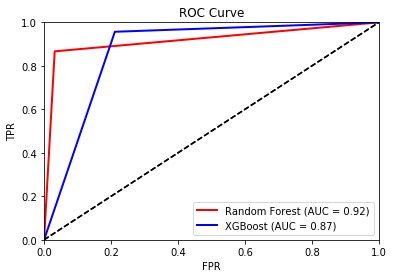

In [44]:
# Function to plot ROC curve
def plotAUCCurve(actual, predictions, color, model_name):
    fpr, tpr, threshold = roc_curve(actual, predictions)
    area = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label= model_name+' (AUC = %0.2f)' % area)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")


# Calling function to plot ROC's for Random Forest and XGBoost
plotAUCCurve(normalized_test_data.iloc[:,-3:-2], rf_binary_predictions, "red", "Random Forest")
plotAUCCurve(normalized_test_data.iloc[:,-3:-2], xgb_binary_predictions, "blue", "XGBoost")
plt.show()

#### Once again, the performance of XGBoost is proven better. Although, it has a slightly lower AUC, it has a higher "True Positive Rate" compared to "Random Forest". For the problem of Network Intrusion Detection, we believe that TPR is more important than FPR.

## B) Multiclass Classification Results

### 2) Accuracy vs Precision vs Recall

In [45]:
# Creating a Data Frame for storing results
results_2 = pd.DataFrame(index=['Random Forest', 'XGBoost'], columns=['Accuracy', 'Precision', 'Recall'])

# Storing results for Random Forest model
results_2.loc['Random Forest']['Accuracy'] = str(rf_multi_accuracy*100)+"%"
results_2.loc['Random Forest']['Precision'] = str(rf_multi_precision*100)+"%"
results_2.loc['Random Forest']['Recall'] = str(rf_multi_recall*100)+"%"

# Storing results for XGBoost model
results_2.loc['XGBoost']['Accuracy'] = str(xgb_multi_accuracy*100)+"%"
results_2.loc['XGBoost']['Precision'] = str(xgb_multi_precision*100)+"%"
results_2.loc['XGBoost']['Recall'] = str(xgb_multi_recall*100)+"%"

In [46]:
results_2

,Accuracy,Precision,Recall
Random Forest,71.8371630138%,79.4672936935%,71.8371630138%
XGBoost,52.5598690552%,42.9791060201%,52.5598690552%


#### Although not performing at its best, Random Forest still beats XGBoost while performing Multiclass classification. The reason for this can be attributed to higher class imbalance in that data.

### 3) Area Under ROC

#### Random Forest

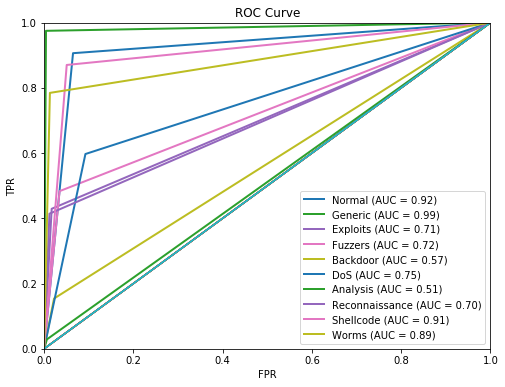

In [47]:
# Function to plot ROC curve
def plotAUCCurve(actual, predictions, model_name, l):
    fpr, tpr, threshold = roc_curve(actual, predictions)
    area = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label= l+' (AUC = %0.2f)' % area)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

plt.figure(figsize=(8,6))
for l in attack_labels:
    predicted = pd.Series(rf_multiclass_predictions).map({l:1}).fillna(0)
    actual = pd.Series(normalized_test_data['attack_cat_labels']).map({l:1}).fillna(0)
    plotAUCCurve(actual, predicted, "Random Forest", mapping[l])
plt.show()

#### XGBoost

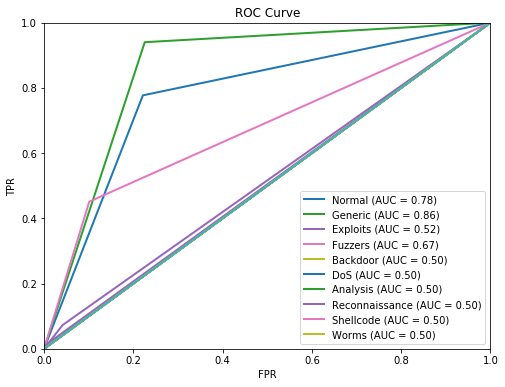

In [48]:
plt.figure(figsize=(8,6))
for l in attack_labels:
    predicted = pd.Series(pred_label).map({l:1}).fillna(0)
    actual = pd.Series(normalized_test_data['attack_cat_labels']).map({l:1}).fillna(0)
    plotAUCCurve(actual, predicted, "XGBoost", mapping[l])
plt.show()

#### From the ROC's shown above we can conclude that both the models underperform for some common Network attack types such as "Backdoor", "Analysis", "Reconnaissance". The probable reason for this can be the lower count of network packets with these specific attack categories. 